# Forecasting Fate: Analyzing Capital Punishment Trends in the US (1976-2016)
### In this notebook file, we will load, clean, explore, and model data regarding Capital punishment inorder to answer questions our group has regarding the data
Lets start by importing all the libraries needed for this project


In [328]:
# These are the pip installs needed for the project
! pip install matplotlib
! pip install pandas
! pip install numpy
! pip install seaborn
! pip install sklearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to us

In [329]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, tree
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler



### First we will start by loading our data and cleaning it slightly
When looking at the data initially, we noticed that there where some entries which contained "other" as their race. Since race is a crucial part of this data, we decided to leave it out instead of replacing the data with the most common race inorder to not skew our results

In [330]:
data = pd.read_csv('data.csv')
data = data[data["Race"] != "other"]
print(data.head())

         Date             Name  Age   Sex   Race   Crime  Victim Count  \
0  01/17/1977     Gary Gilmore   36  Male  White  Murder             1   
1  05/25/1979  John Spenkelink   30  Male  White  Murder             1   
2  10/22/1979     Jesse Bishop   46  Male  White  Murder             1   
3  03/09/1981      Steven Judy   24  Male  White  Murder             4   
4  08/10/1982    Frank Coppola   38  Male  White  Murder             1   

         Victim Sex Victim Race             County State   Region  \
0              Male       White               Utah    UT     West   
1              Male       White               Leon    FL    South   
2              Male       White              Clark    NV     West   
3  2 Male, 2 Female       White             Marion    IN  Midwest   
4              Male       White  Newport News City    VA    South   

          Method Juvenile Volunteer Federal Foreign National  
0   Firing Squad       No       Yes      No               No  
1  Electrocuti

### Next, I noticed that we have some features which do contain numerical data, which is only "Age" and "Victem Count"
When looking describing them, we see the count, mean, std, min, max and quartiles of the data. This information will help us answer 2 of the questions we have imposed in our project

In [331]:
print(data.describe())

               Age  Victim Count
count  1442.000000   1442.000000
mean     41.479889      1.537448
std       9.471676      4.495852
min      22.000000      1.000000
25%      34.000000      1.000000
50%      40.000000      1.000000
75%      47.000000      1.750000
max      77.000000    168.000000


<p>In addition to describing the two numerical features, we also plotted them in a whisker box plot too catch any outliers. In this case, we see that therer are 6 outliers in the data for "Age", and multiple for "Victim Count"
Our group has decided not to mess with the outliers in "Victem Count" since there are many, and we want the data to be as truthfull to the origianl dataset which came from a reputale source. We are also going to use that data when modeling, so its better to just leave it as is.
As for the "Age" feature, We have decided [insert plan for outliers] </p>
<p>We also decided to make a scatter plot to plot both of the numerical features to see if they where any correlations in the data between them. It was suprizing to see that it followed a uniform linear pattern, but there was one otlier that was messing with the scatterplot, so we decided to remove it for a better reading</p>
<p>When removing that outlier, we see that the data was infact not uniform, but actually was influenced heavly from that outlier, in reality, there seems to follow a normal distribution when ploting "Age" and "Victim Count". We have also reploted the box and whisker plot for "Victim Count," and saw that the vast majority of people sentenced to capital punishment, Killed approximatly 1 person. We also redescribed the data and calculated probabilities since it followes a normal discribution</p>

<Axes: xlabel='Age'>

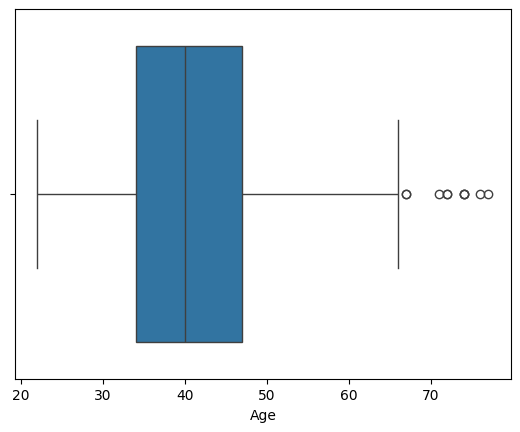

In [332]:
sns.boxplot(x=data["Age"])

<Axes: xlabel='Victim Count'>

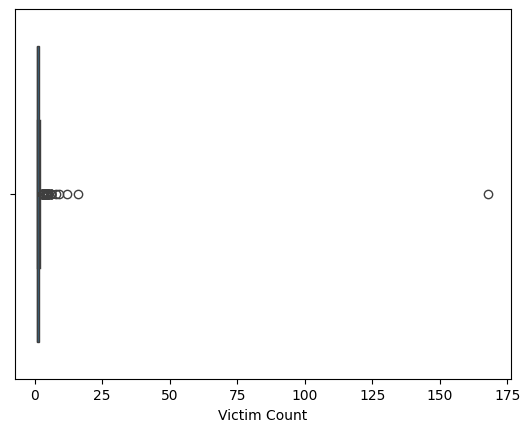

In [333]:
sns.boxplot(x=data["Victim Count"])

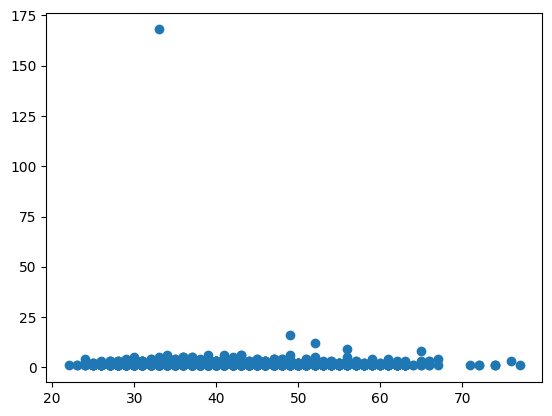

In [334]:
X = data['Age']
y = data['Victim Count']
plt.scatter(X, y)
plt.show()

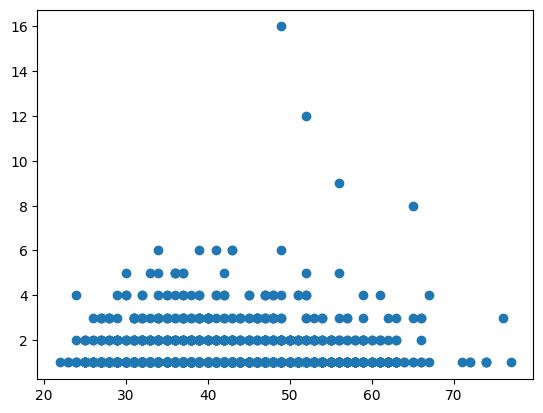

In [335]:
data = data[(data["Victim Count"] < 100) & (data["Race"] != "other")]
X = data['Age']
y = data['Victim Count']
plt.scatter(X, y)
plt.show()

<Axes: xlabel='Age', ylabel='Density'>

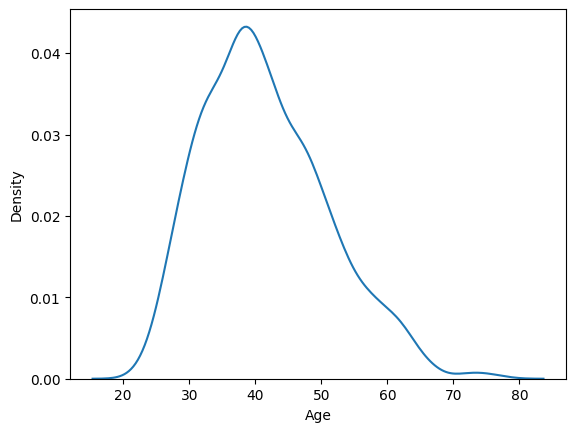

In [336]:
sns.kdeplot(data=data, x="Age")

<Axes: xlabel='Victim Count', ylabel='Density'>

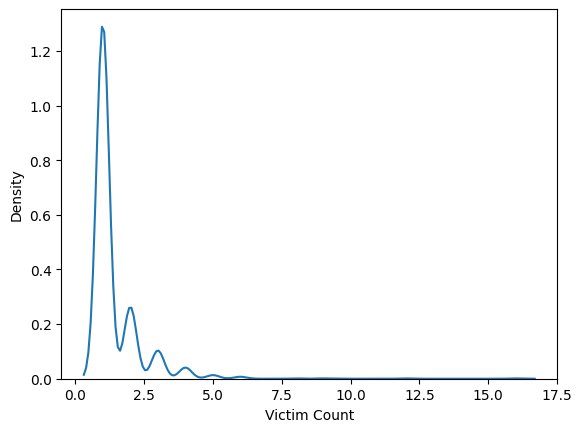

In [337]:
sns.kdeplot(data=data, x="Victim Count")

<Axes: xlabel='Victim Count'>

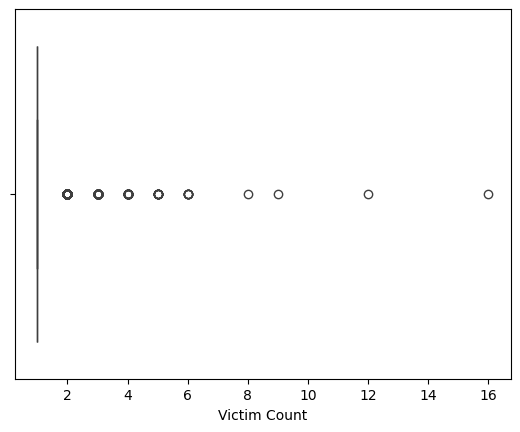

In [338]:
sns.boxplot(x=data["Victim Count"])

In [339]:
print(data.describe())

               Age  Victim Count
count  1441.000000   1441.000000
mean     41.485774      1.421929
std       9.472327      0.985121
min      22.000000      1.000000
25%      34.000000      1.000000
50%      40.000000      1.000000
75%      47.000000      1.000000
max      77.000000     16.000000


<p>No that the outlier has been removed, we now see that it somewhat follows a normal distributions </p>
<p>Using that information, we can then use the normal distribution curve to predict the probabilites of the features</p>

In [340]:
q3, q1 = np.percentile(X, [75 ,25])
q2 = np.percentile(X, 50)
iqr = q3 - q1
mean = np.mean(X)
sdev = np.std(X)
print("iqr", iqr)
print("q3", q3)
print("q2", q2)
print("q1", q1)

iqr 13.0
q3 47.0
q2 40.0
q1 34.0


In [341]:
probLT = norm.cdf(q1, mean, sdev)
probBetw = norm.cdf(q2, mean, sdev) - probLT
print("The probability that a randomly selected person \n has an Age less than or equal to " + str(q1) + " is ", end="")
print('%.3f' % probLT + ".")
print("The probability that a randomly selected person \n has an Age between " + str(q1) + " and " + str(q2)+ " is ", end="")
print('%.3f' % probBetw + ".")
print("The probability that a randomly selected person \n has an Age greater than " + str(q1) + " is ", end="")
print('%.3f' % (1 - probLT) + ".")

The probability that a randomly selected person 
 has an Age less than or equal to 34.0 is 0.215.
The probability that a randomly selected person 
 has an Age between 34.0 and 40.0 is 0.223.
The probability that a randomly selected person 
 has an Age greater than 34.0 is 0.785.


### Now that the numerical features are done, we now move onto the categorical features
The only graphing methods we where shown in class to deal with these are pie, histogram, and bar charts. We learned that pie charts are highly frowned upon due to many issues in class, so we just used bar and histogram charts. These are the following results from the graphing and they will also help us in answering more questions we have about the data

1425
16
Probablity for Male = 98.88965995836226
Probablity for Female = 1.1103400416377516


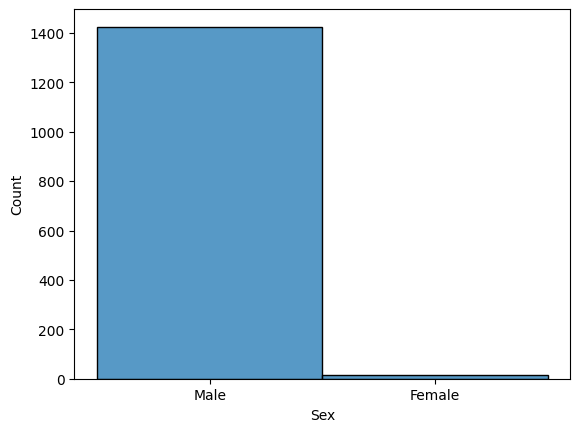

In [342]:
sns.histplot(x='Sex', data=data)
print(len(data[data["Sex"] == "Male"]))
print(len(data[data["Sex"] == "Female"]))
print("Probablity for Male =", (len(data[data["Sex"] == "Male"]) / len(data["Sex"])) * 100)
print("Probablity for Female =", (len(data[data["Sex"] == "Female"]) / len(data["Sex"]))* 100)

Percentage of whites          =  55.6557945870923
Percentage of black           =  34.35114503816794
Percentage of latino          =  8.327550312283137
Percentage of native American =  1.1103400416377516
Percentage of other           =  0.13879250520471895


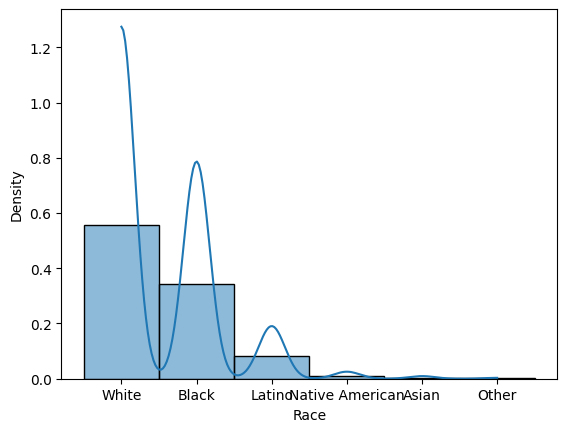

In [343]:
sns.histplot(x='Race', data=data, stat="density", kde=True)
print("Percentage of whites          = ", len(data[data['Race'] == 'White']) / len(data["Race"]) * 100)
print("Percentage of black           = ", len(data[data['Race'] == 'Black']) / len(data["Race"]) * 100)
print("Percentage of latino          = ", len(data[data['Race'] == 'Latino']) / len(data["Race"]) * 100)
print("Percentage of native American = ", len(data[data['Race'] == 'Native American']) / len(data["Race"]) * 100)
print("Percentage of other           = ", len(data[data['Race'] == 'Other']) / len(data["Race"]) * 100)

Percentage of Fireing Squad     =  0.0
Percentage of Electrocution     =  10.964607911172797
Percentage of Gas Chamber       =  0.7633587786259541
Percentage of Lethal Injection  =  87.8556557945871
Percentage of Hanging           =  0.2081887578070784


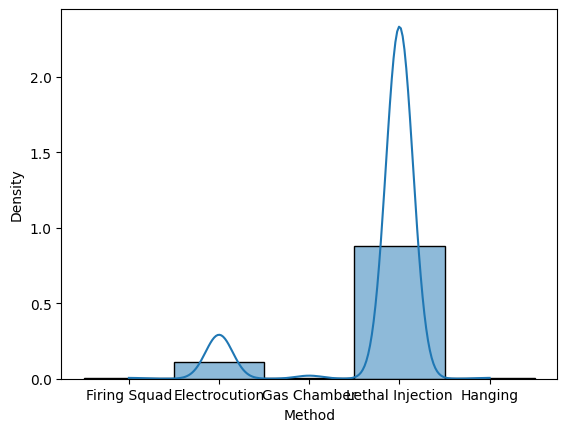

In [344]:
sns.histplot(x='Method', data=data, stat="density", kde=True)
print("Percentage of Fireing Squad     = ", len(data[data['Method'] == 'Fireing Squad']) / len(data["Method"]) * 100)
print("Percentage of Electrocution     = ", len(data[data['Method'] == 'Electrocution']) / len(data["Method"]) * 100)
print("Percentage of Gas Chamber       = ", len(data[data['Method'] == 'Gas Chamber']) / len(data["Method"]) * 100)
print("Percentage of Lethal Injection  = ", len(data[data['Method'] == 'Lethal Injection']) / len(data["Method"]) * 100)
print("Percentage of Hanging           = ", len(data[data['Method'] == 'Hanging']) / len(data["Method"]) * 100)

<p>I came to the realization that you can also see what is going on per year every time</p>
<p>That is what I did, after figuring out how to do it, i made some other onces since its basically copy and paste</p>

<Axes: xlabel='Date'>

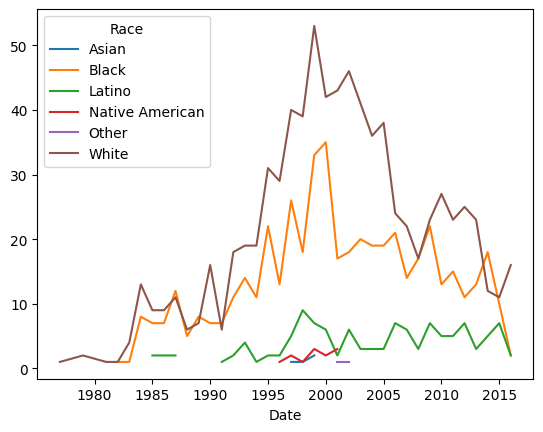

In [345]:
dataMulti = pd.read_csv('data.csv', parse_dates=['Date'])
table = pd.pivot_table(dataMulti, index=[dataMulti['Date'].dt.year, dataMulti['Race']], aggfunc="size").unstack(level=1)                   
table.plot()

<Axes: xlabel='Date'>

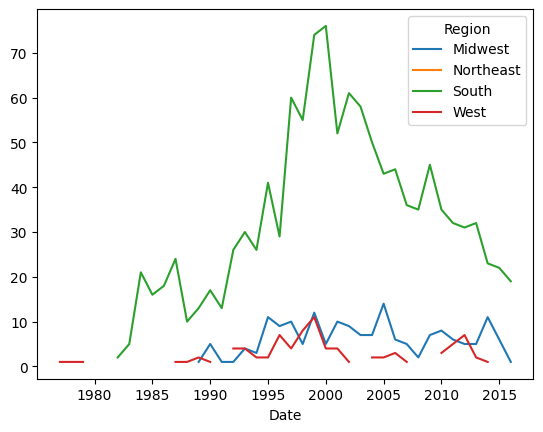

In [346]:
table = pd.pivot_table(dataMulti, index=[dataMulti['Date'].dt.year, dataMulti['Region']], aggfunc="size").unstack(level=1)                   
table.plot()

<Axes: xlabel='Date'>

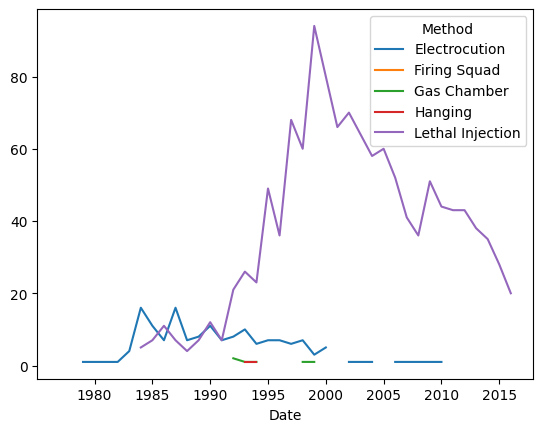

In [347]:
table = pd.pivot_table(dataMulti, index=[dataMulti['Date'].dt.year, dataMulti['Method']], aggfunc="size").unstack(level=1)                   
table.plot()

### Finally, we will now predict future values using models
<p>We have chosen to do a logistic regression to find out the probability of a person prosecuted to captial punishment will be a male or female. We start with logistic regression in which we will hot deck the "Sex" feature and determine the probabilty </p>
<p>The logistic model does a really poor job of perdicting offerenr sex due to the large amount of males that make it seem like females are outliers. The cause of this might a comentary of current socio-political factors</p>

/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0, 0.5, 'Probability of Race')

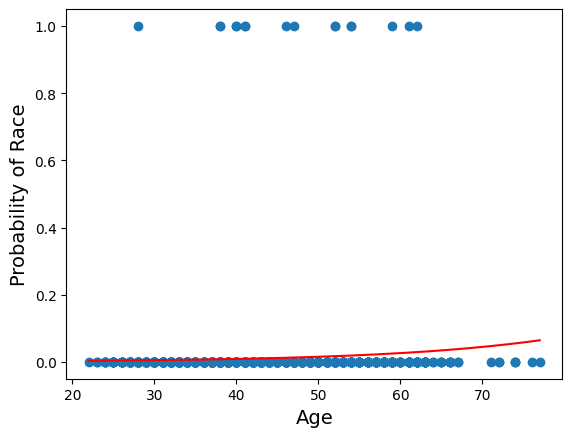

In [348]:
data.loc[data['Sex'] == "Male", "Sex"] = 0
data.loc[data['Sex'] == "Female", "Sex"] = 1
X = data[['Age']].values.reshape(-1, 1).astype('int')
y = data[['Sex']].values.reshape(-1, 1).astype('int')

logisticModel = LogisticRegression()
logisticModel.fit(X, y)
plt.scatter(X, y)
xDelta = np.linspace(X.min(), X.max(), 10000)
yPredicted = logisticModel.predict(X).reshape(-1, 1).astype(int)
yDeltaProb = logisticModel.predict_proba(xDelta.reshape(-1, 1))[:, 1]
plt.plot(xDelta, yDeltaProb, color='red')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Probability of Race', fontsize=14)

In [349]:
print(logisticModel.coef_)
print(logisticModel.intercept_)

pHatProb = logisticModel.predict_proba([[53]])
print(pHatProb[0])

print(
    "A offender with regard to capital punishment age 53 has predicted probability: \n",
    pHatProb[0][0],
    "of being a male\n",
    pHatProb[0][1],
    "of being a female\n",
    "and overall is classified to be Male",
)

[[0.05511475]]
[-6.92114646]
[0.98201493 0.01798507]
A offender with regard to capital punishment age 53 has predicted probability: 
 0.9820149321338814 of being a male
 0.017985067866118615 of being a female
 and overall is classified to be Male


### Next We will move on to somne decision trees
<p>These types of models are one of the only ways to predict categorical features, and a really good way to predict regression, That is why I did it.</p>
<p>This information might also translate into more discussion regarding socio political states</p>

In [375]:
# Save output features as y
yTree = data[['Method']]

# Save input features as x
XTree = data[['Age', 'Victim Count']]

# Initialize the model
classtreeModel = DecisionTreeClassifier(max_depth=3)
X_train, X_test, y_train, y_test = train_test_split(XTree, yTree, test_size=0.3, random_state=42)

# Fit the model
classtreeModel = classtreeModel.fit(X_train, y_train)
print(export_text(classtreeModel, feature_names=XTree.columns.to_list()))

|--- Age <= 36.50
|   |--- Victim Count <= 4.50
|   |   |--- Victim Count <= 1.50
|   |   |   |--- class: Lethal Injection
|   |   |--- Victim Count >  1.50
|   |   |   |--- class: Lethal Injection
|   |--- Victim Count >  4.50
|   |   |--- class: Electrocution
|--- Age >  36.50
|   |--- Age <= 47.50
|   |   |--- Age <= 37.50
|   |   |   |--- class: Lethal Injection
|   |   |--- Age >  37.50
|   |   |   |--- class: Lethal Injection
|   |--- Age >  47.50
|   |   |--- Age <= 53.50
|   |   |   |--- class: Lethal Injection
|   |   |--- Age >  53.50
|   |   |   |--- class: Lethal Injection



/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

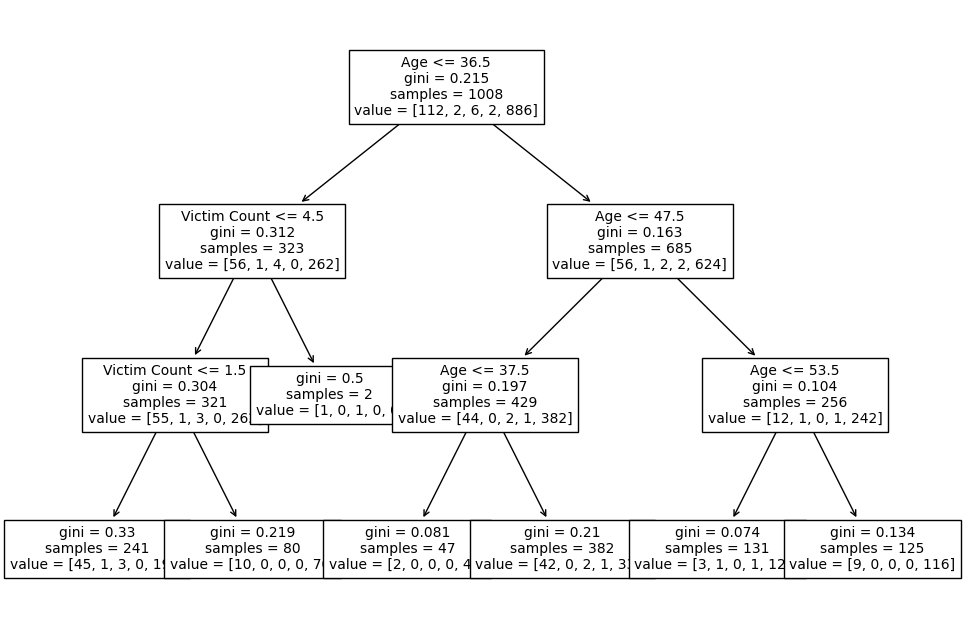

In [376]:
# Resize the plotting window
plt.figure(figsize=[12, 8])

# Values in brackets represent classes in alphabetical order
# [Adelie, Chinstrap, Gentoo]
p = tree.plot_tree(classtreeModel, feature_names=XTree.columns, filled=False, fontsize=10)

Cross-entropy:  0.9120279784034288
Error rate:  0.1293302540415704
Gini index:  0.21139733832741958


/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

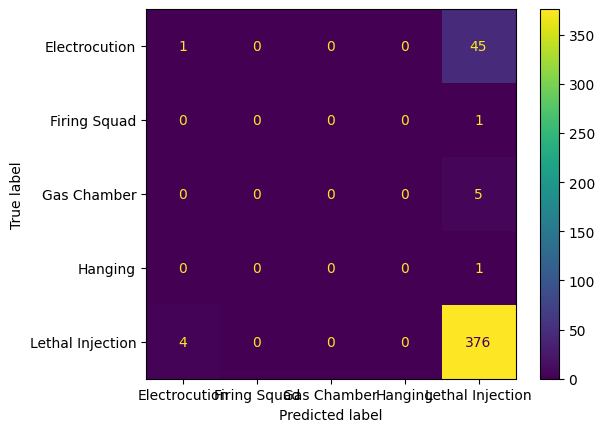

In [384]:
# Calculate cross-entroy and error rate

print("Cross-entropy: ", metrics.log_loss(y_test, classtreeModel.predict_proba(X_test)))
print("Error rate: ", 1 - metrics.accuracy_score(y_test, classtreeModel.predict(X_test)))
# Calculate the Gini index
probs = pd.DataFrame(data=classtreeModel.predict_proba(X_test))
print("Gini index: ", (probs * (1 - probs)).mean().sum())

# Calculate the confusion matrix
metrics.confusion_matrix(y_test, classtreeModel.predict(X_test))

# Plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, classtreeModel.predict(X_test))

In [369]:
# Save output features as y
yTree1 = data[['Race']]

# Save input features as x
XTree1 = data[['Age', 'Victim Count']]

# Scales the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(XTree1), columns=['Age', 'Victim Count'])

# Initialize the model
classtreeModel1 = DecisionTreeClassifier(max_depth=3)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, yTree1, test_size=0.3, random_state=0)

# Fit the model
classtreeModel1 = classtreeModel1.fit(X_train1, y_train1)
print(export_text(classtreeModel1, feature_names=XTree1.columns.to_list()))

|--- Age <= 0.53
|   |--- Age <= -0.74
|   |   |--- Age <= -1.58
|   |   |   |--- class: White
|   |   |--- Age >  -1.58
|   |   |   |--- class: Black
|   |--- Age >  -0.74
|   |   |--- Victim Count <= 0.08
|   |   |   |--- class: White
|   |   |--- Victim Count >  0.08
|   |   |   |--- class: White
|--- Age >  0.53
|   |--- Age <= 1.59
|   |   |--- Victim Count <= 1.09
|   |   |   |--- class: White
|   |   |--- Victim Count >  1.09
|   |   |   |--- class: White
|   |--- Age >  1.59
|   |   |--- Age <= 3.54
|   |   |   |--- class: White
|   |   |--- Age >  3.54
|   |   |   |--- class: Native American



/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

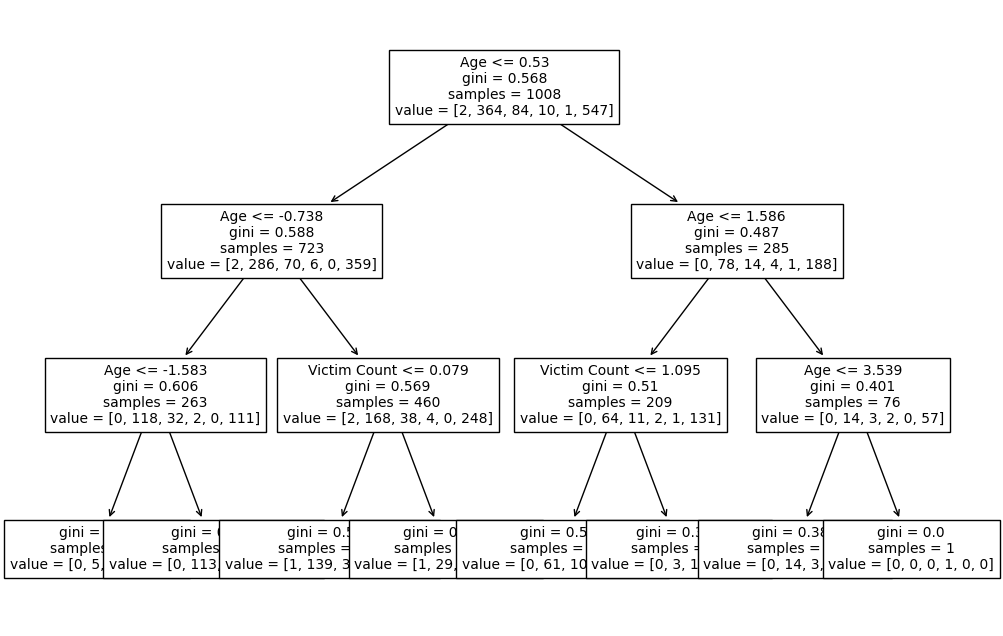

In [370]:
# Resize the plotting window
plt.figure(figsize=[12, 8])

# Values in brackets represent classes in alphabetical order
# [Adelie, Chinstrap, Gentoo]
p1 = tree.plot_tree(classtreeModel1, feature_names=XTree1.columns, filled=False, fontsize=10)

Cross-entropy:  1.2736600631475556
Error rate:  0.41570438799076215
Gini index:  0.5433538830257153


/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/aero/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

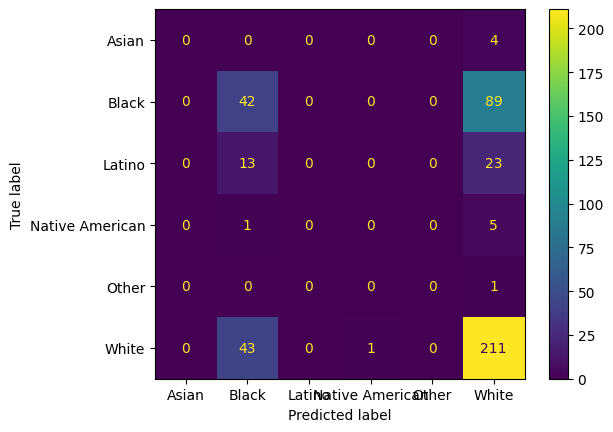

In [385]:
# Calculate cross-entroy and error rate

print("Cross-entropy: ", metrics.log_loss(y_test1, classtreeModel1.predict_proba(X_test1)))
print("Error rate: ", 1 - metrics.accuracy_score(y_test1, classtreeModel1.predict(X_test1)))
# Calculate the Gini index
probs1 = pd.DataFrame(data=classtreeModel1.predict_proba(X_test1))
print("Gini index: ", (probs1 * (1 - probs1)).mean().sum())

# Calculate the confusion matrix
metrics.confusion_matrix(y_test1, classtreeModel1.predict(X_test1))

# Plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test1, classtreeModel1.predict(X_test1))